In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import altair as alt
import dask.dataframe as dd

pd.set_option('display.max_columns', None)

filepath = r'data'
filepath_history_data = r'data/history-per-year.parquet'
filepath_to_csv = r'data'

In [2]:
#import of history_aggregated, holidays_events, items, oil, stores, transactions


all_files = glob.glob(filepath + "/*.parquet") # find all parquet files in path

df_dict = dict() # create empty dictionary for storing dataframes

#loop through each file in path and add dataframe to dictionary
for filename in all_files:
    name_df = os.path.basename(filename)
    name_df = name_df.replace('.parquet','')
    df_dict[name_df] = pd.read_parquet(filename)

In [3]:
#import of total history per month/year


#filepath_to_parquet = r'data'


df_dict_hist = dict() # create empty dictionary for storing history dataframes

#creates the history dataframes and adds them to the dictionary
for yr in range(2013,2018,1):
    for mth in range(1,13,1):
        full_path = filepath_history_data + '/year=' + str(yr) + '/month=' + str(mth)
        file_found = glob.glob(full_path + "/*.parquet") # find all parquet files in path
        period = (str(yr) + '0' + str(mth)) if mth < 10 else (str(yr) + str(mth))
        name_df = 'history_' + period
        if len(file_found) > 0:
            df_dict_hist[name_df] = pd.read_parquet(file_found[0]) #import of parquet file
            df_dict_hist[name_df]['year'] = yr
            df_dict_hist[name_df]['month'] = mth
            df_dict_hist[name_df]['period'] = period
            df_dict_hist[name_df]['date'] = pd.to_datetime(str(yr) + '-' + str(mth) + '-' + df_dict_hist[name_df]['day'].astype(str)).dt.strftime('%Y-%m-%d')
        else:
            pass

#create history dataframe
count = 0
for df in df_dict_hist:
    count +=1
    if count == 1:
        df_total_history = df_dict_hist[df]
    else:
        df_new = df_dict_hist[df]
        df_total_history = pd.concat([df_total_history,df_new], sort=False)
        
      
df_dict_hist.clear() #deleting the dictionary to clean up memory
del df_new #df_new not required anymore

#outputting df_total_history to csv file (required for dask)
#df_total_history.to_parquet(filepath_to_parquet + '/total_history.parquet', engine='pyarrow')
df_total_history.to_csv(filepath_to_csv + '/total_history.csv', index=False)



In [3]:
#cleaning up of holiday calendar
df_holidays1 = df_dict['holidays_events'].copy()
df_holidays1 = df_holidays1[df_holidays1['transferred']==False] #removes the transferred True since these are considered normal business days
df_holidays1['key'] = df_holidays1['date'] + df_holidays1['locale_name'] #create unique key
df_holidays2 = df_holidays1.copy()



In [4]:
#rename each column of df_holidays2 with postfix 2
for col in df_holidays2:
    df_holidays2 = df_holidays2.rename(columns={col: col + '2'})

In [5]:
#join the holiday data frames for the duplicarte analysis
df_holidays_merged = df_holidays1.merge(df_holidays2, how='inner', left_on=['key'], right_on=['key2'])

In [6]:
#count duplicates in dataframe and enrich to holiday merged dataframe
df_cnt = df_holidays_merged.groupby(['key'])['key2'].count()
df_cnt = df_cnt.to_frame().reset_index()
df_cnt = df_cnt.rename(columns={'key': 'key_cnt'})
df_cnt = df_cnt.rename(columns={'key2': 'cnt'})

df_holidays_merged = df_holidays_merged.merge(df_cnt, how='inner', left_on=['key'], right_on=['key_cnt']) #enrich merged dataframe with count
#drop the duplicate rows where description1 matches description2
df_holidays_merged.drop(df_holidays_merged[(df_holidays_merged['cnt']>1) & (df_holidays_merged['description'] == df_holidays_merged['description2'])].index, inplace=True)

In [7]:
#change field values of duplicate holidays
df_holidays_merged.loc[df_holidays_merged['cnt'] > 1,'type'] = df_holidays_merged['type'] + '/' + df_holidays_merged['type2']
df_holidays_merged.loc[df_holidays_merged['cnt'] > 1,'description'] = df_holidays_merged['description'] + '/' + df_holidays_merged['description2']

In [8]:
#remove the duplicate date/local_name combinations and create the total dataframe
df_holidays_merged['date_converted'] = pd.to_datetime(df_holidays_merged['date'])
df_holidays_merged['Rank'] = df_holidays_merged.groupby('key')['date_converted'].rank(method='first')
df_holidays_final = df_holidays_merged[df_holidays_merged['Rank'] == 1]
df_holidays_final = df_holidays_final[['date','type','locale','locale_name','description','transferred']]


In [9]:
#convert date field to date format
df_holidays_final['date'] = pd.to_datetime(df_holidays_merged['date'])

In [10]:
#remove redundant help dataframes due to saving memory
del df_holidays1
del df_holidays2
del df_holidays_merged
del df_cnt

In [11]:

def create_holiday_df_with_selection_locale(df,selection_field,selection):
    #this function creates a new df based on an existing with where clause on existing field
    #furthermore function renames each field in dataframe with the selected value as postfix
    df = df[df[selection_field]==selection]
    for col in df:
        df = df.rename(columns={col: col + '_' + str(selection)})
    return df







In [15]:
#convert date column from object to date xxx
df_dict['transactions']['date']=pd.to_datetime(df_dict['transactions']['date'])
df_holidays_final['date']=pd.to_datetime(df_holidays_final['date'])
df_dict['oil']['date']=pd.to_datetime(df_dict['oil']['date'])
df_total_history['date']=pd.to_datetime(df_total_history['date'])

In [16]:
df_holidays_final_national = create_holiday_df_with_selection_locale(df_holidays_final,'locale','National')

In [17]:
#add remapped national holiday field
df_holidays_final_national['description_National_Remapped'] = df_holidays_final_national['description_National']
dict_remap_events = {'Black Friday' : 'Black Friday','Carnaval' : 'Carnaval','Dia del Trabajo' : 'Dia del Trabajo','Independencia de Guayaquil' : 'Independencia de Guayaquil','Viernes Santo' : 'Viernes Santo','Puente Primer dia del ano' : 'Primer dia del ano','Mundial de futbol Brasil: Semifinales' : 'Mundial de futbol','Mundial de futbol Brasil: Ecuador-Francia' : 'Mundial de futbol','Navidad-1' : 'Navidad','Dia del Trabajo/Terremoto Manabi+15' : 'Terremotos', 'Terremoto Manabi+1' : 'Terremotos', 'Terremoto Manabi+22/Dia de la Madre' : 'Terremotos', 'Terremoto Manabi+29' : 'Terremotos', 'Terremoto Manabi+8' : 'Terremotos'}
df_holidays_final_national['description_National_Remapped']= df_holidays_final_national['description_National_Remapped'].map(dict_remap_events)


In [18]:
df_holidays_final_regional = create_holiday_df_with_selection_locale(df_holidays_final,'locale','Regional')

In [19]:
df_holidays_final_local = create_holiday_df_with_selection_locale(df_holidays_final,'locale','Local')

In [20]:
#create year column in history aggregated
df_dict['history_aggregated']['year'] =  pd.DatetimeIndex(df_dict['history_aggregated']['date']).year

In [21]:
def convert_numbers_to_smallest_size_func(df_input):
    """convert integers and floats to smallest size needed"""
    for old,new in [('integer','unsigned'), ('float','float')]:
        for col in df_input.select_dtypes(include=old).columns:
            df_input[col] = pd.to_numeric(df_input[col],downcast=new)



In [22]:
#downcast number to smallest size
convert_numbers_to_smallest_size_func(df_total_history)
convert_numbers_to_smallest_size_func(df_dict['history_aggregated'])
convert_numbers_to_smallest_size_func(df_dict['transactions'])
convert_numbers_to_smallest_size_func(df_dict['items'])
convert_numbers_to_smallest_size_func(df_dict['stores'])




In [24]:
#show the first records of the total history
df_total_history.head()

In [21]:
#show datatypes of the total history
df_total_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 1570967
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           uint32        
 1   store_nbr    uint8         
 2   item_nbr     uint32        
 3   unit_sales   float32       
 4   onpromotion  object        
 5   day          uint8         
 6   year         uint16        
 7   month        uint8         
 8   period       object        
 9   date         datetime64[ns]
dtypes: datetime64[ns](1), float32(1), object(2), uint16(1), uint32(2), uint8(3)
memory usage: 5.7+ GB


In [22]:
#describe the generic statistics of the total history
df_total_history.describe().transpose()

count          mean           std      min          25%  \
id          125497040.0  6.274852e+07  3.622788e+07      0.0  31374259.75   
store_nbr   125497040.0  2.746458e+01  1.633051e+01      1.0        12.00   
item_nbr    125497040.0  9.727692e+05  5.205336e+05  96995.0    522383.00   
unit_sales  125497040.0  5.319669e+00  2.306714e+01 -15372.0         2.00   
day         125497040.0  1.560188e+01  8.816411e+00      1.0         8.00   
year        125497040.0  2.015223e+03  1.299140e+00   2013.0      2014.00   
month       125497040.0  6.334971e+00  3.392866e+00      1.0         3.00   

                   50%          75%          max  
id          62748519.5  94122779.25  125497039.0  
store_nbr         28.0        43.00         54.0  
item_nbr      959500.0   1354380.00    2127114.0  
unit_sales         4.0         9.00      89440.0  
day               15.0        23.00         31.0  
year            2015.0      2016.00       2017.0  
month              6.0         9.00         12.0

In [23]:
def check_missing_values(df):
    #function to check for missing values in dataframe
    total_values = df.shape[0]
    for col in df:
        ratio = round((100*df[col].isnull().sum())/total_values,2)
        print('Column ' + '"' + col + '"' + ' has ' + df[col].isnull().sum().astype(str) + ' missing values of a total of ' + str(total_values) + '.Ratio: ' + str(ratio) + '%')

#callling the function on dataframe total history since .info() is not working
check_missing_values(df_total_history)
        

Column "id" has 0 missing values of a total of 125497040.Ratio: 0.0%
Column "store_nbr" has 0 missing values of a total of 125497040.Ratio: 0.0%
Column "item_nbr" has 0 missing values of a total of 125497040.Ratio: 0.0%
Column "unit_sales" has 0 missing values of a total of 125497040.Ratio: 0.0%
Column "onpromotion" has 21657651 missing values of a total of 125497040.Ratio: 17.26%
Column "day" has 0 missing values of a total of 125497040.Ratio: 0.0%
Column "year" has 0 missing values of a total of 125497040.Ratio: 0.0%
Column "month" has 0 missing values of a total of 125497040.Ratio: 0.0%
Column "period" has 0 missing values of a total of 125497040.Ratio: 0.0%
Column "date" has 0 missing values of a total of 125497040.Ratio: 0.0%


In [25]:
#show the first records of the final holiday calendar
df_holidays_final.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [26]:
#show datatypes of the final holiday calendar
df_holidays_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 0 to 351
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         331 non-null    datetime64[ns]
 1   type         331 non-null    object        
 2   locale       331 non-null    object        
 3   locale_name  331 non-null    object        
 4   description  331 non-null    object        
 5   transferred  331 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 15.8+ KB


In [27]:
#delete redundant dataframe for memory reasons
del df_holidays_final

In [23]:
#show the first records of the aggregated history
df_dict['history_aggregated'].head()

onpromotion  item_nbr    week                      date  unit_sales_sum  \
0        False    764438  201323 2013-06-04 00:00:00+00:00          1925.0   
1        False    764438  201324 2013-06-11 00:00:00+00:00          1516.0   
2        False    764438  201325 2013-06-18 00:00:00+00:00          1656.0   
3        False    764438  201326 2013-06-25 00:00:00+00:00          1610.0   
4        False    764438  201327 2013-07-02 00:00:00+00:00          1987.0   

   count     family  class  perishable  year  
0    180  GROCERY I   1072           0  2013  
1    164  GROCERY I   1072           0  2013  
2    176  GROCERY I   1072           0  2013  
3    177  GROCERY I   1072           0  2013  
4    182  GROCERY I   1072           0  2013

In [24]:
#show datatypes of the aggregated history
df_dict['history_aggregated'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948220 entries, 0 to 948219
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   onpromotion     948220 non-null  bool               
 1   item_nbr        948220 non-null  uint32             
 2   week            948220 non-null  uint32             
 3   date            948220 non-null  datetime64[ns, UTC]
 4   unit_sales_sum  948220 non-null  float32            
 5   count           948220 non-null  uint16             
 6   family          948220 non-null  category           
 7   class           948220 non-null  uint16             
 8   perishable      948220 non-null  uint8              
 9   year            948220 non-null  uint16             
dtypes: bool(1), category(1), datetime64[ns, UTC](1), float32(1), uint16(3), uint32(2), uint8(1)
memory usage: 26.2 MB


In [25]:
##describe the generic statistics the history aggregated data
df_dict['history_aggregated'].describe().transpose()

count          mean            std       min       25%  \
item_nbr        948220.0  1.033259e+06  524408.628519   96995.0  584125.0   
week            948220.0  2.015584e+05     121.625703  201301.0  201447.0   
unit_sales_sum  948220.0  1.131573e+03    2019.575439   -9757.0     137.0   
count           948220.0  1.323501e+02     103.404191       1.0      27.0   
class           948220.0  2.152235e+03    1337.917574    1002.0    1072.0   
perishable      948220.0  3.201377e-01       0.466530       0.0       0.0   
year            948220.0  2.014832e+03       0.854884    2013.0    2014.0   

                      50%        75%           max  
item_nbr        1047756.0  1456935.0  2.127114e+06  
week             201552.0   201644.0  2.017330e+05  
unit_sales_sum      627.0     1290.0  1.209818e+05  
count               131.0      213.0  3.780000e+02  
class              2022.0     2718.0  7.780000e+03  
perishable            0.0        1.0  1.000000e+00  
year               2015.0     2015.0  2.016000e+03

In [26]:
#show the first records of the transactions dataframe
df_dict['transactions'].head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [27]:
#show datatypes of the transactions dataframe
df_dict['transactions'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  uint8         
 2   transactions  83488 non-null  uint16        
dtypes: datetime64[ns](1), uint16(1), uint8(1)
memory usage: 897.0 KB


In [28]:
#describe the generic statistics of transactions data
df_dict['transactions'].describe().transpose()

count         mean         std  min     25%     50%     75%  \
store_nbr     83488.0    26.939237   15.608204  1.0    13.0    27.0    40.0   
transactions  83488.0  1694.602158  963.286644  5.0  1046.0  1393.0  2079.0   

                 max  
store_nbr       54.0  
transactions  8359.0

In [29]:
#show the first records of the stores dataframe
df_dict['stores'].head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [30]:
#show datatypes of the stores dataframe
df_dict['stores'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     uint8 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     uint8 
dtypes: object(3), uint8(2)
memory usage: 1.5+ KB


In [31]:
#describe the generic statistics of stores data
df_dict['stores'].describe().transpose()

count       mean        std  min    25%   50%    75%   max
store_nbr   54.0  27.500000  15.732133  1.0  14.25  27.5  40.75  54.0
cluster     54.0   8.481481   4.693395  1.0   4.00   8.5  13.00  17.0

In [32]:
#show the first records of the items dataframe
df_dict['items'].head()

item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1

In [33]:
#show datatypes of the items dataframe
df_dict['items'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   uint32
 1   family      4100 non-null   object
 2   class       4100 non-null   uint16
 3   perishable  4100 non-null   uint8 
dtypes: object(1), uint16(1), uint32(1), uint8(1)
memory usage: 60.2+ KB


In [34]:
#describe the generic statistics of items data
df_dict['items'].describe().transpose()

count          mean            std      min        25%  \
item_nbr    4100.0  1.251436e+06  587687.220310  96995.0  818110.75   
class       4100.0  2.169650e+03    1484.910900   1002.0    1068.00   
perishable  4100.0  2.404878e-01       0.427432      0.0       0.00   

                  50%        75%        max  
item_nbr    1306197.5  1904918.0  2134244.0  
class          2004.0     2990.5     7780.0  
perishable        0.0        0.0        1.0

In [35]:
#show the first records of the oil dataframe
df_dict['oil'].head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [36]:
#show datatypes of the oil dataframe
df_dict['oil'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [37]:
#describe the generic statistics of oil data
df_dict['oil'].describe().transpose()

count       mean        std    min     25%    50%    75%     max
dcoilwtico  1175.0  67.714366  25.630476  26.19  46.405  53.19  95.66  110.62

Note that the oil dataframe has empty values in the price field (dcoilwtico) and the total history dataframe has missing values in the Promotion column (onPromotion)

In [42]:
#delete original total history dataframe to safe memory
del df_total_history

In [38]:
#dask_df_total_history = dd.read_parquet(filepath_to_parquet + '/total_history.parquet', engine='pyarrow')
dtypes={'id': 'uint32', 'store_nbr': 'uint8','item_nbr': 'uint32','item_nbr': 'uint32','unit_sales': 'float32','day': 'uint8','year': 'uint16','month': 'uint8','onpromotion': 'category','period': 'category'}

dask_df_total_history = dd.read_csv(filepath_to_csv + '/total_history.csv',dtype=dtypes,parse_dates=['date'])



In [39]:
dask_df_total_history['date'] = dask_df_total_history['date'].map_partitions(pd.to_datetime,format='%Y/%m/%d',meta = ('datetime64[ns]')) #convert date field to date format

In [40]:
#history dataframe enriched with item and store info
dask_df_history_enriched = dask_df_total_history.merge(df_dict['items'], how='left', left_on=['item_nbr'], right_on=['item_nbr'])
dask_df_history_enriched = dask_df_history_enriched.merge(df_dict['stores'], how='left', left_on=['store_nbr'], right_on=['store_nbr'])

In [41]:
#merging history enriched with national holidays / events
dask_df_history_enriched = dask_df_history_enriched.merge(df_holidays_final_national, how='left', left_on=['date'], right_on=['date_National'])






In [42]:
#function to delete unneccesary fields
def delete_columns_in_df(df,list_fields):
    for col in list_fields:
        del df[col]
    return df

In [43]:
#after merging delete unneccesary fields
fieldlist = ['date_National','locale_National','locale_name_National','transferred_National']

dask_df_history_enriched = delete_columns_in_df(dask_df_history_enriched,fieldlist)

In [44]:
#merging history enriched with regional holidays / events
dask_df_history_enriched = dask_df_history_enriched.merge(df_holidays_final_regional, how='left', left_on=['date','state'], right_on=['date_Regional','locale_name_Regional'])

In [45]:
#after merging delete unneccesary fields
fieldlist = ['date_Regional','locale_Regional','locale_name_Regional','transferred_Regional']
dask_df_history_enriched = delete_columns_in_df(dask_df_history_enriched,fieldlist)

In [46]:
#merging history enriched with local holidays / events
dask_df_history_enriched = dask_df_history_enriched.merge(df_holidays_final_local, how='left', left_on=['date','city'], right_on=['date_Local','locale_name_Local'])

In [47]:
#after merging delete unneccesary fields
fieldlist = ['date_Local','locale_Local','locale_name_Local','transferred_Local']
dask_df_history_enriched = delete_columns_in_df(dask_df_history_enriched,fieldlist)

In [48]:
dask_df_history_enriched['onpromotion'] = dask_df_history_enriched['onpromotion'].astype('category')
dask_df_history_enriched['familiy'] = dask_df_history_enriched['period'].astype('category')
dask_df_history_enriched['city'] = dask_df_history_enriched['city'].astype('category')
dask_df_history_enriched['state'] = dask_df_history_enriched['state'].astype('category')
dask_df_history_enriched['type'] = dask_df_history_enriched['type'].astype('category')
dask_df_history_enriched['type_National'] = dask_df_history_enriched['type_National'].astype('category')
dask_df_history_enriched['description_National'] = dask_df_history_enriched['description_National'].astype('category')
dask_df_history_enriched['description_National_Remapped'] = dask_df_history_enriched['description_National_Remapped'].astype('category')
dask_df_history_enriched['type_Regional'] = dask_df_history_enriched['type_Regional'].astype('category')
dask_df_history_enriched['description_Regional'] = dask_df_history_enriched['description_Regional'].astype('category')
dask_df_history_enriched['type_Local'] = dask_df_history_enriched['type_Local'].astype('category')
dask_df_history_enriched['description_Local'] = dask_df_history_enriched['description_Local'].astype('category')

In [49]:
#function to aggregate dataframes
def aggregate_dataframe(df,groupby_fields,aggregation_field,aggregation_type):
    df_agg = df.groupby(groupby_fields)[aggregation_field].agg(aggregation_type)
    df_agg = df_agg.reset_index()
    return df_agg

In [235]:
#function to create index figures in dataframe
def create_index_figures(df,start_number,numeric_column1,numeric_column2,lbl_column1,lbl_column2):
    df[lbl_column1] = 100*(df[numeric_column1] / df[numeric_column1].shift(1))
    df[lbl_column2] = 100*(df[numeric_column2] / df[numeric_column2].shift(1))
    df = df.sort_values(by=['date'],ascending=True)
    df.loc[0,[lbl_column1]] = start_number
    df.loc[0,[lbl_column2]] = start_number
    return df

## Analyzing transactions

In [51]:
#enriched the transactions file with store info
df_transactions_enriched = df_dict['transactions'].merge(df_dict['stores'], how='left', left_on=['store_nbr'], right_on=['store_nbr'])

In [52]:
#add field with store number and city concatenated
df_transactions_enriched['Store_City'] =  df_transactions_enriched['city'].astype(str) + '_' + df_transactions_enriched['store_nbr'].astype(str)

In [53]:
#Enrich transactions file with national holidays
df_transactions_enriched = df_transactions_enriched.merge(df_holidays_final_national, how='left', left_on=['date'], right_on=['date_National'])

In [54]:
#after merging delete unneccesary fields
fieldlist = ['date_National','locale_National','locale_name_National','transferred_National']
df_transactions_enriched = delete_columns_in_df(df_transactions_enriched,fieldlist)

In [55]:
#Enrich transactions file with regional holidays
df_transactions_enriched = df_transactions_enriched.merge(df_holidays_final_regional, how='left', left_on=['date','state'], right_on=['date_Regional','locale_name_Regional'])

In [56]:
#after merging delete unneccesary fields
fieldlist = ['date_Regional','locale_Regional','locale_name_Regional','transferred_Regional']
df_transactions_enriched = delete_columns_in_df(df_transactions_enriched,fieldlist)

In [57]:
#Enrich transactions file with local holidays
df_transactions_enriched = df_transactions_enriched.merge(df_holidays_final_local, how='left', left_on=['date','city'], right_on=['date_Local','locale_name_Local'])

In [58]:
#after merging delete unneccesary fields
fieldlist = ['date_Local','locale_Local','locale_name_Local','transferred_Local']
df_transactions_enriched = delete_columns_in_df(df_transactions_enriched,fieldlist)

In [59]:
df_transactions_enriched.head()

date  store_nbr  transactions     city        state type  cluster  \
0 2013-01-01         25           770  Salinas  Santa Elena    D        1   
1 2013-01-02          1          2111    Quito    Pichincha    D       13   
2 2013-01-02          2          2358    Quito    Pichincha    D       13   
3 2013-01-02          3          3487    Quito    Pichincha    D        8   
4 2013-01-02          4          1922    Quito    Pichincha    D        9   

   Store_City type_National description_National  \
0  Salinas_25       Holiday   Primer dia del ano   
1     Quito_1           NaN                  NaN   
2     Quito_2           NaN                  NaN   
3     Quito_3           NaN                  NaN   
4     Quito_4           NaN                  NaN   

  description_National_Remapped type_Regional description_Regional type_Local  \
0                           NaN           NaN                  NaN        NaN   
1                           NaN           NaN                  NaN        NaN   
2                           NaN           NaN                  NaN        NaN   
3                           NaN           NaN                  NaN        NaN   
4                           NaN           NaN                  NaN        NaN   

  description_Local  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

In [60]:
df_transactions_enriched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83488 entries, 0 to 83487
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           83488 non-null  datetime64[ns]
 1   store_nbr                      83488 non-null  uint8         
 2   transactions                   83488 non-null  uint16        
 3   city                           83488 non-null  object        
 4   state                          83488 non-null  object        
 5   type                           83488 non-null  object        
 6   cluster                        83488 non-null  uint8         
 7   Store_City                     83488 non-null  object        
 8   type_National                  6640 non-null   object        
 9   description_National           6640 non-null   object        
 10  description_National_Remapped  1850 non-null   object        
 11  type_Regional  

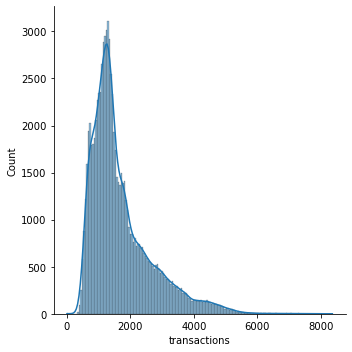

In [62]:
#shows the distribution of transactions
sns.displot(df_transactions_enriched['transactions'],kde=True);

In [63]:
print('Kurtosis of transactions: ',df_transactions_enriched['transactions'].kurtosis())
print('Skewness of transactions: ',df_transactions_enriched['transactions'].skew())

Kurtosis of transactions:  2.5672134576238794
Skewness of transactions:  1.51835135809795


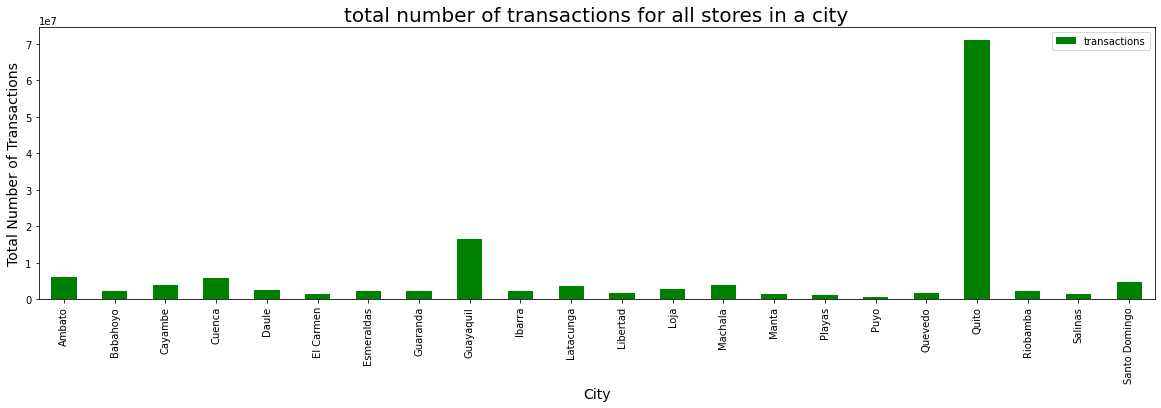

In [108]:
#total number of transactions for a city
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'city','transactions','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='city',y='transactions',color='green')

plot.set_title('total number of transactions for all stores in a city', fontsize = 20)
plot.set_xlabel('City', fontsize = 14)
plot.set_ylabel('Total Number of Transactions', fontsize = 14);

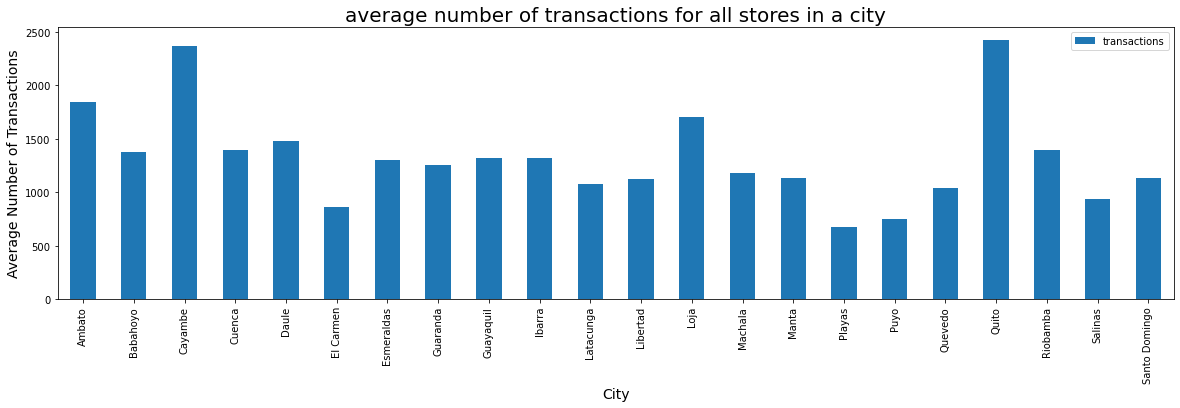

In [91]:
#average number of transactions for a city
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'city','transactions','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='city',y='transactions')

plot.set_title('average number of transactions for all stores in a city', fontsize = 20)
plot.set_xlabel('City', fontsize = 14)
plot.set_ylabel('Average Number of Transactions', fontsize = 14);

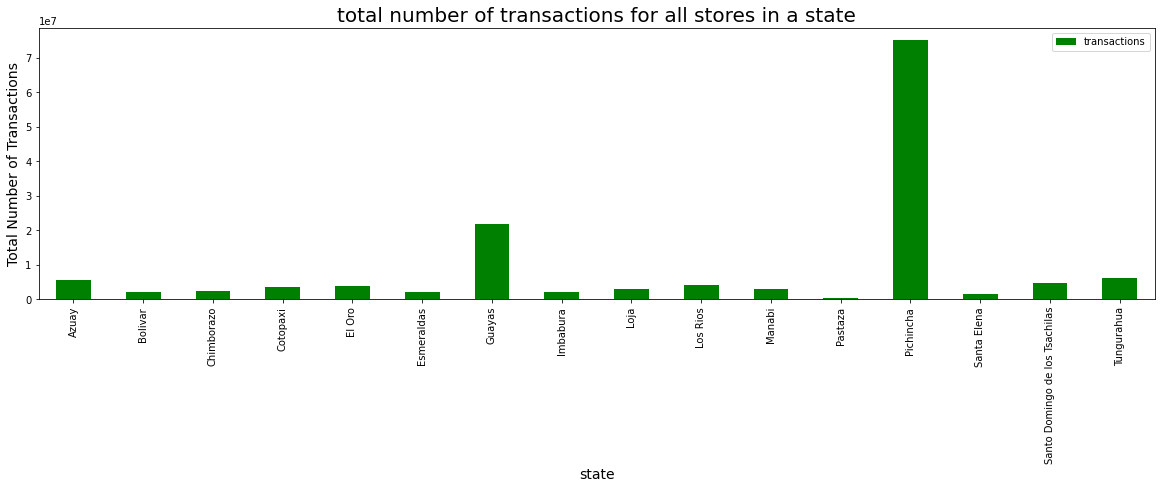

In [110]:
#total number of transactions for a state
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'state','transactions','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='state',y='transactions',color='green')


plot.set_title('total number of transactions for all stores in a state', fontsize = 20)
plot.set_xlabel('state', fontsize = 14)
plot.set_ylabel('Total Number of Transactions', fontsize = 14);

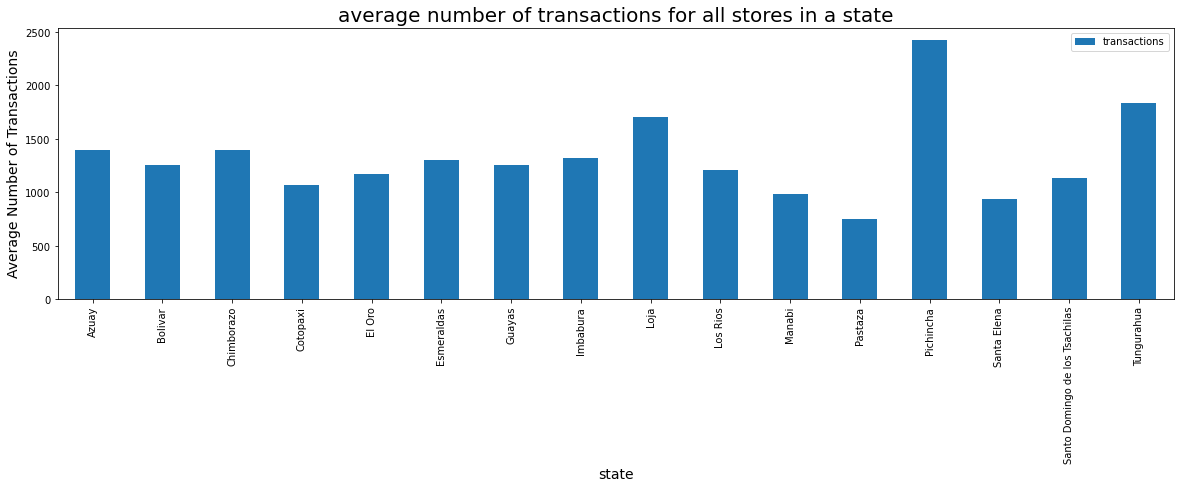

In [92]:
#average number of transactions for a state
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'state','transactions','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='state',y='transactions')


plot.set_title('average number of transactions for all stores in a state', fontsize = 20)
plot.set_xlabel('state', fontsize = 14)
plot.set_ylabel('Average Number of Transactions', fontsize = 14);

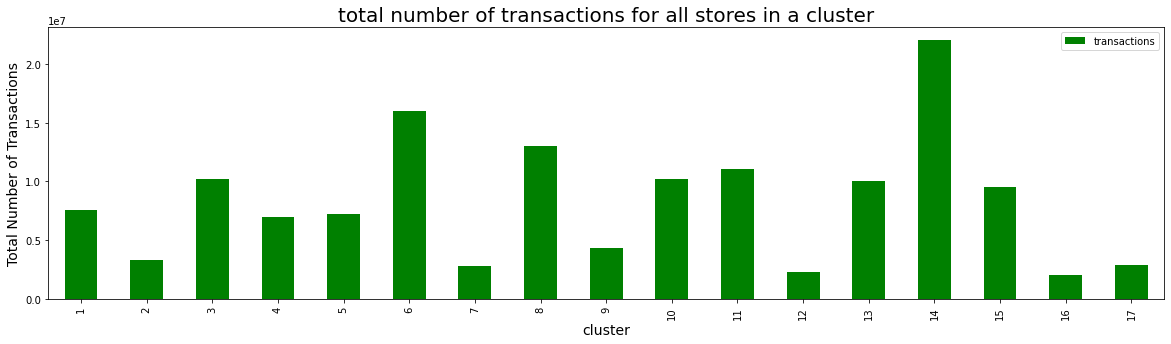

In [111]:
#total number of transactions for a cluster
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'cluster','transactions','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='cluster',y='transactions',color='green')

plot.set_title('total number of transactions for all stores in a cluster', fontsize = 20)
plot.set_xlabel('cluster', fontsize = 14)
plot.set_ylabel('Total Number of Transactions', fontsize = 14);

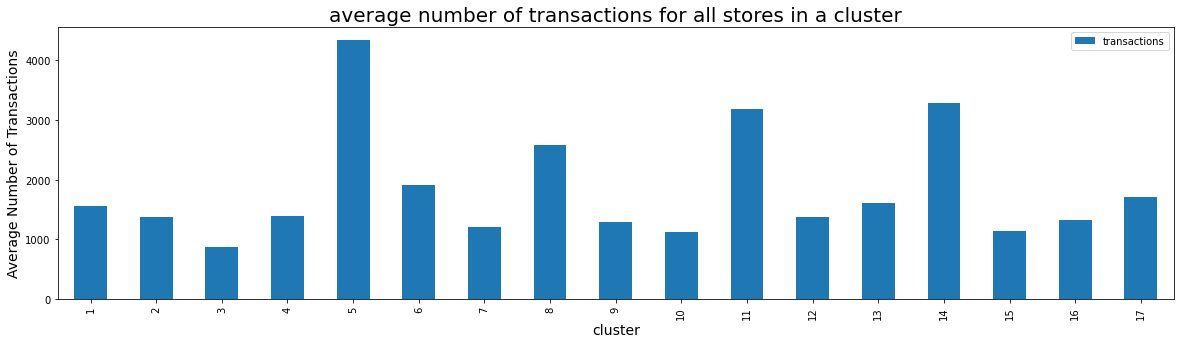

In [93]:
#average number of transactions for a cluster
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'cluster','transactions','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='cluster',y='transactions')

plot.set_title('average number of transactions for all stores in a cluster', fontsize = 20)
plot.set_xlabel('cluster', fontsize = 14)
plot.set_ylabel('Average Number of Transactions', fontsize = 14);

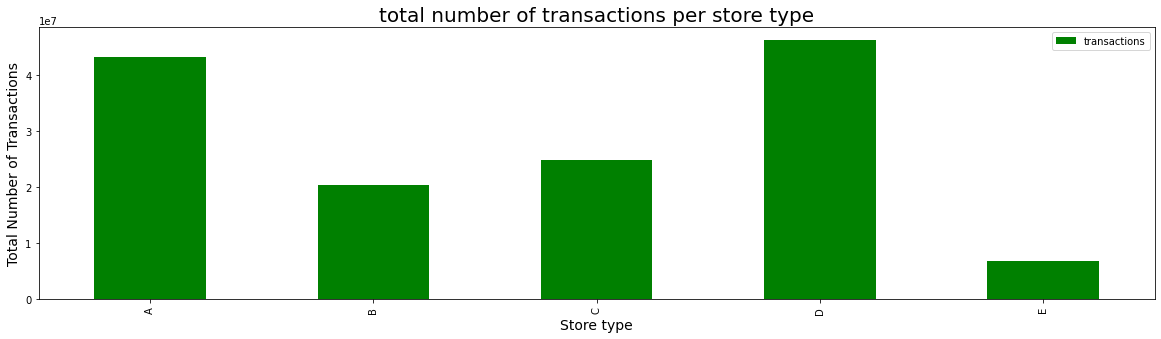

In [112]:
#total number of transactions per store type
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'type','transactions','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='type',y='transactions',color='green')

plot.set_title('total number of transactions per store type', fontsize = 20)
plot.set_xlabel('Store type', fontsize = 14)
plot.set_ylabel('Total Number of Transactions', fontsize = 14);

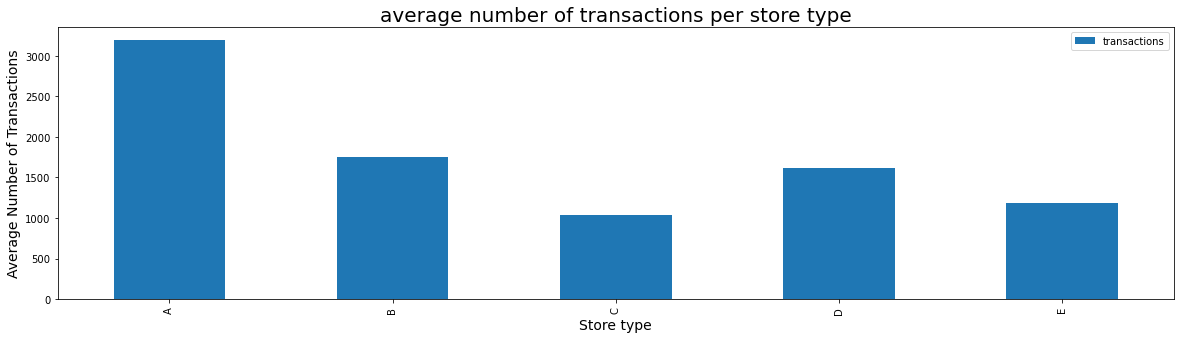

In [95]:
#average number of transactions per store type
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'type','transactions','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='type',y='transactions')

plot.set_title('average number of transactions per store type', fontsize = 20)
plot.set_xlabel('Store type', fontsize = 14)
plot.set_ylabel('Average Number of Transactions', fontsize = 14);



In [96]:
df_transactions_enriched['year'] =  pd.DatetimeIndex(df_transactions_enriched['date']).year

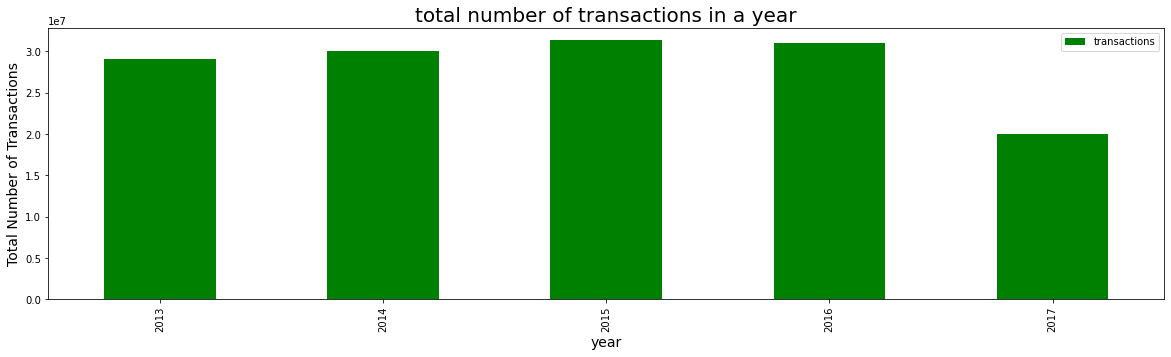

In [113]:
#total number of transactions per year
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'year','transactions','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='year',y='transactions',color='green')

plot.set_title('total number of transactions in a year', fontsize = 20)
plot.set_xlabel('year', fontsize = 14)
plot.set_ylabel('Total Number of Transactions', fontsize = 14);

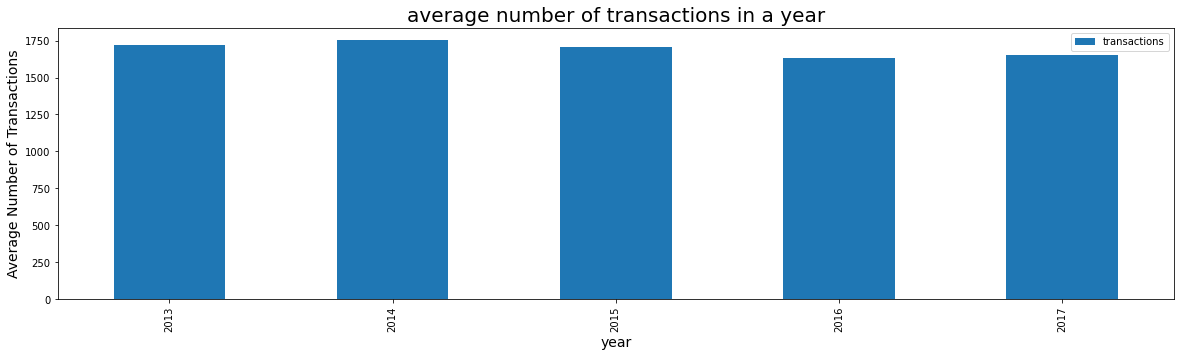

In [97]:
#average number of transactions per year
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'year','transactions','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='year',y='transactions')

plot.set_title('average number of transactions in a year', fontsize = 20)
plot.set_xlabel('year', fontsize = 14)
plot.set_ylabel('Average Number of Transactions', fontsize = 14);

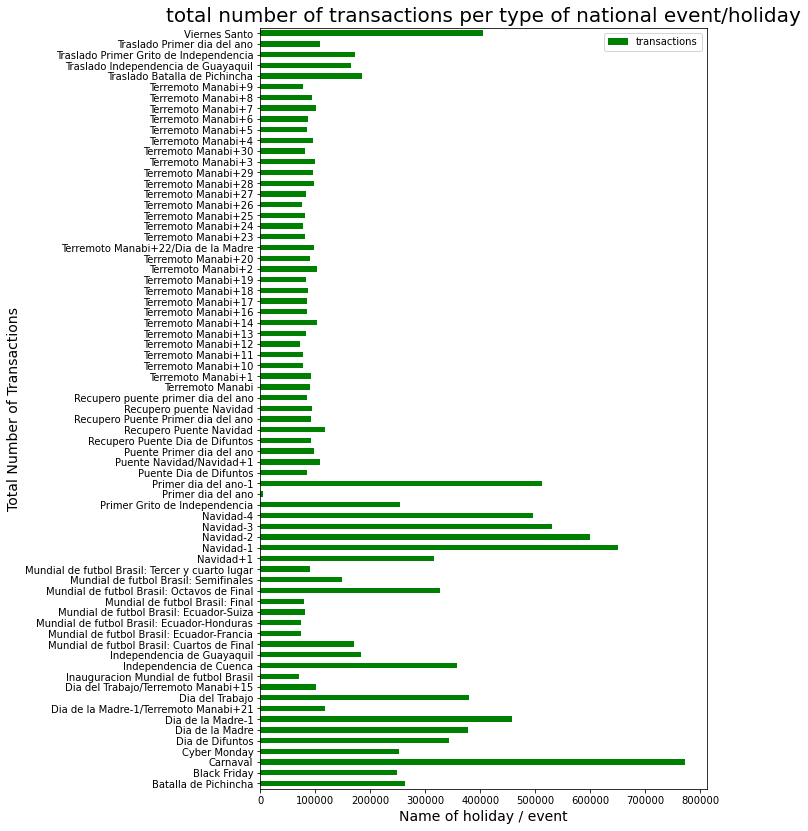

In [114]:
#total number of transactions per type of national event/holiday
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'description_National','transactions','sum')
plot = df_temp_chart.plot(kind='barh',figsize=(8,14), x='description_National',y='transactions',color='green')

plot.set_title('total number of transactions per type of national event/holiday', fontsize = 20)
plot.set_xlabel('Name of holiday / event', fontsize = 14)
plot.set_ylabel('Total Number of Transactions', fontsize = 14);

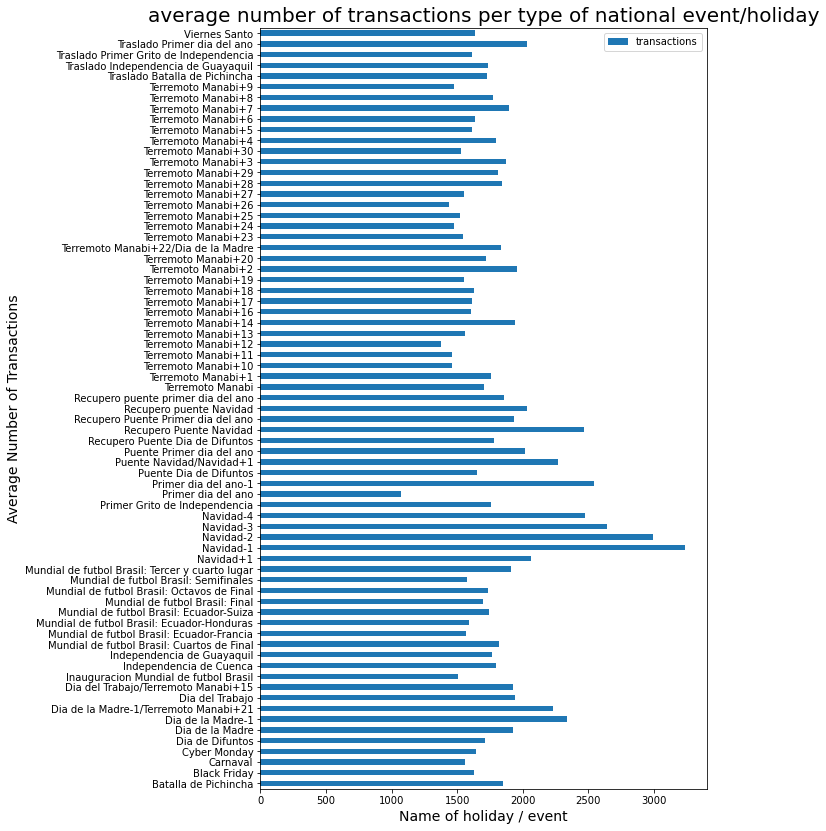

In [98]:
#average number of transactions per type of national event/holiday
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'description_National','transactions','mean')
plot = df_temp_chart.plot(kind='barh',figsize=(8,14), x='description_National',y='transactions')

plot.set_title('average number of transactions per type of national event/holiday', fontsize = 20)
plot.set_xlabel('Name of holiday / event', fontsize = 14)
plot.set_ylabel('Average Number of Transactions', fontsize = 14);

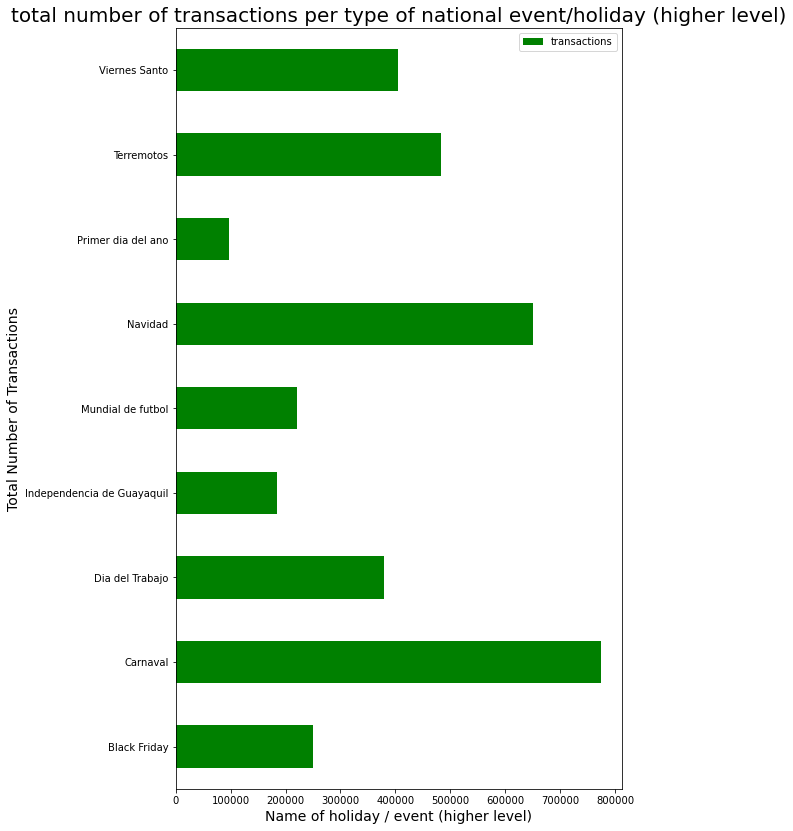

In [115]:
#total number of transactions per type of national event/holiday (higher level)
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'description_National_Remapped','transactions','sum')
plot = df_temp_chart.plot(kind='barh',figsize=(8,14), x='description_National_Remapped',y='transactions',color='green')

plot.set_title('total number of transactions per type of national event/holiday (higher level)', fontsize = 20)
plot.set_xlabel('Name of holiday / event (higher level)', fontsize = 14)
plot.set_ylabel('Total Number of Transactions', fontsize = 14);

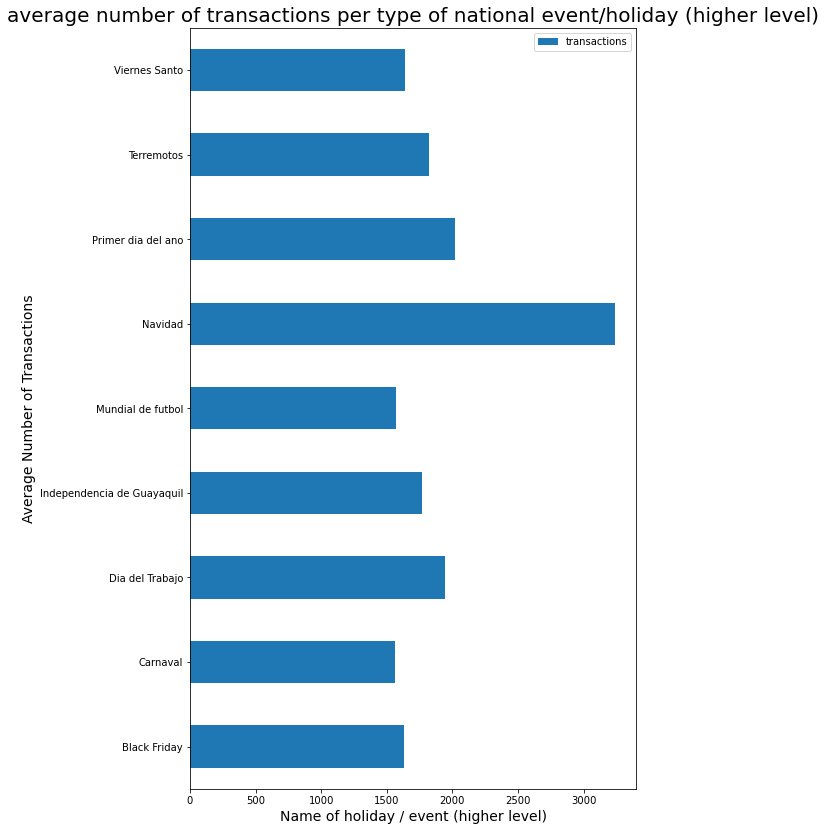

In [99]:
#average number of transactions per type of national event/holiday (higher level)
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'description_National_Remapped','transactions','mean')
plot = df_temp_chart.plot(kind='barh',figsize=(8,14), x='description_National_Remapped',y='transactions')

plot.set_title('average number of transactions per type of national event/holiday (higher level)', fontsize = 20)
plot.set_xlabel('Name of holiday / event (higher level)', fontsize = 14)
plot.set_ylabel('Average Number of Transactions', fontsize = 14);

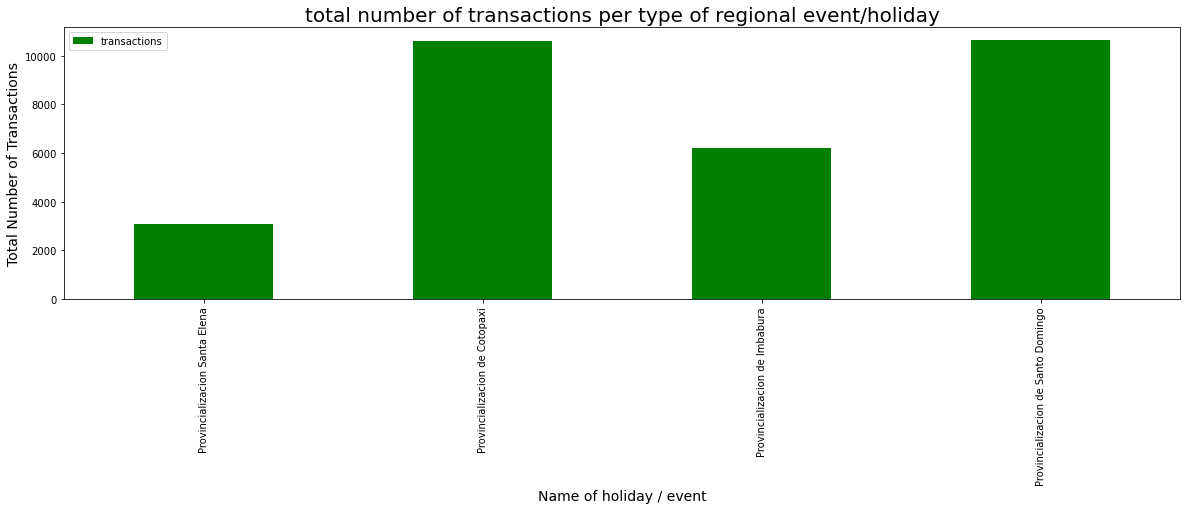

In [117]:
#total number of transactions per type of regional event/holiday
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'description_Regional','transactions','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='description_Regional',y='transactions',color='green')

plot.set_title('total number of transactions per type of regional event/holiday', fontsize = 20)
plot.set_xlabel('Name of holiday / event', fontsize = 14)
plot.set_ylabel('Total Number of Transactions', fontsize = 14);

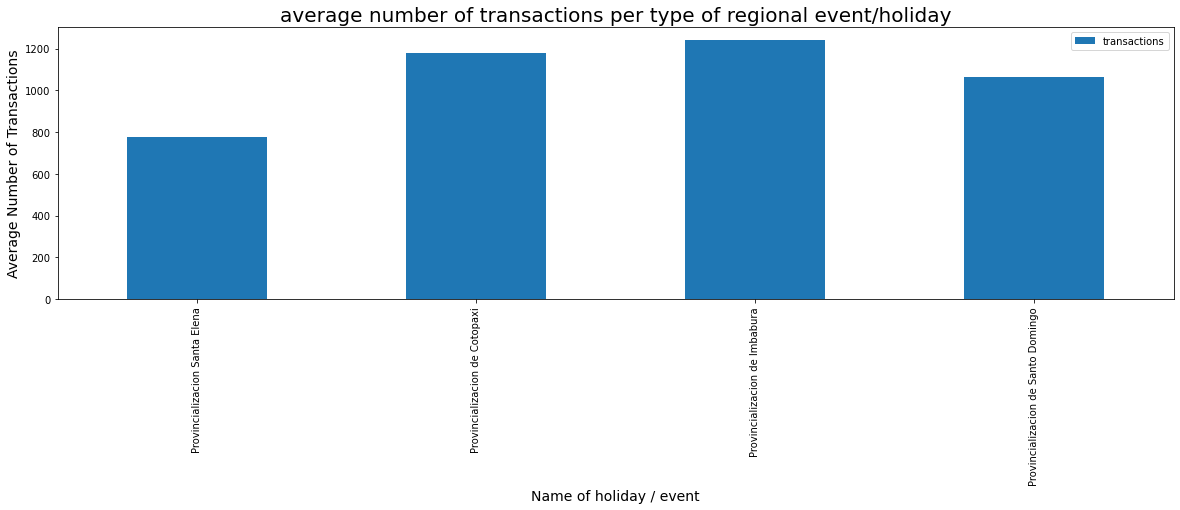

In [118]:
#average number of transactions per type of regional event/holiday
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'description_Regional','transactions','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='description_Regional',y='transactions')

plot.set_title('average number of transactions per type of regional event/holiday', fontsize = 20)
plot.set_xlabel('Name of holiday / event', fontsize = 14)
plot.set_ylabel('Average Number of Transactions', fontsize = 14);

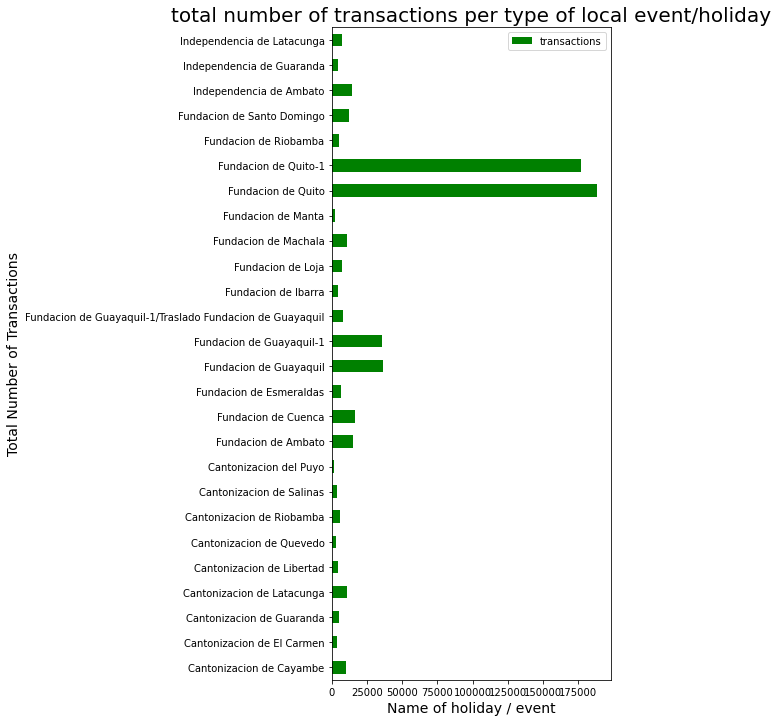

In [119]:
#total number of transactions per type of local event/holiday
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'description_Local','transactions','sum')
plot = df_temp_chart.plot(kind='barh',figsize=(5,12), x='description_Local',y='transactions',color='green')

plot.set_title('total number of transactions per type of local event/holiday', fontsize = 20)
plot.set_xlabel('Name of holiday / event', fontsize = 14)
plot.set_ylabel('Total Number of Transactions', fontsize = 14);

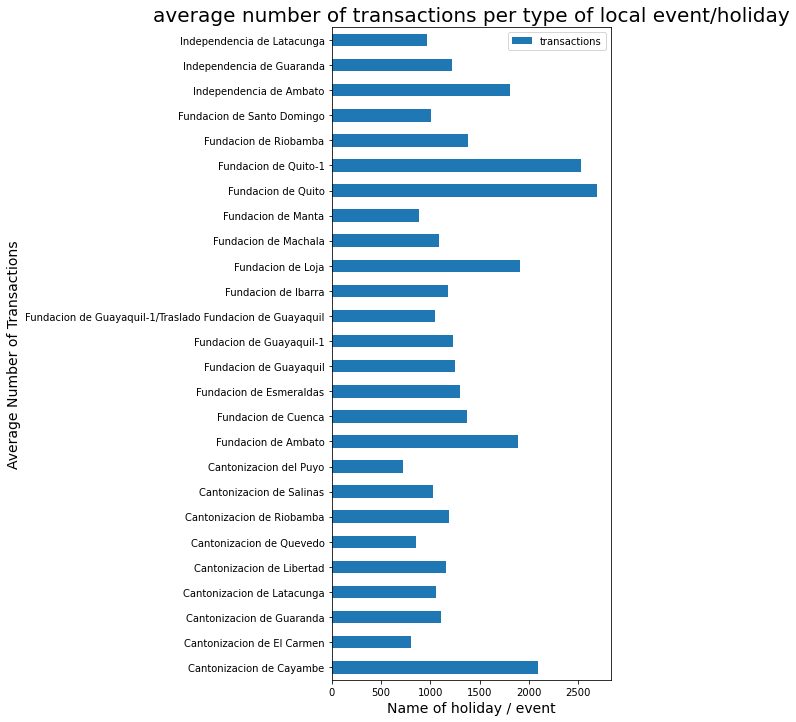

In [120]:
#average number of transactions per type of local event/holiday
df_temp_chart = aggregate_dataframe(df_transactions_enriched,'description_Local','transactions','mean')
plot = df_temp_chart.plot(kind='barh',figsize=(5,12), x='description_Local',y='transactions')

plot.set_title('average number of transactions per type of local event/holiday', fontsize = 20)
plot.set_xlabel('Name of holiday / event', fontsize = 14)
plot.set_ylabel('Average Number of Transactions', fontsize = 14);

## Analyzing historic sales

In [121]:
#Enrich history aggregated file with national holidays
df_dict['history_aggregated']['date'] = df_dict['history_aggregated']['date'].astype('datetime64[ns]') #aparantly the datatypes dates were not the same in both dataframes
df_dict['history_aggregated'] = df_dict['history_aggregated'].merge(df_holidays_final_national, how='left', left_on=['date'], right_on=['date_National'])

In [122]:
#after merging delete unneccesary fields
fieldlist = ['date_National','locale_National','locale_name_National','transferred_National']
df_dict['history_aggregated'] = delete_columns_in_df(df_dict['history_aggregated'],fieldlist)

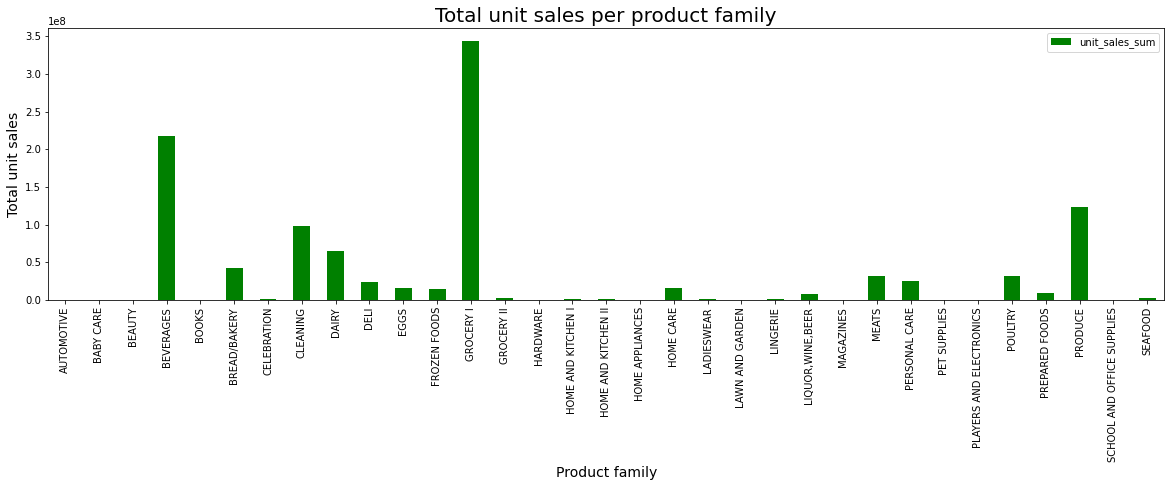

In [133]:
#total unit sales per product family
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'family','unit_sales_sum','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='family',y='unit_sales_sum',color='green')

plot.set_title('Total unit sales per product family', fontsize = 20)
plot.set_xlabel('Product family', fontsize = 14)
plot.set_ylabel('Total unit sales', fontsize = 14);

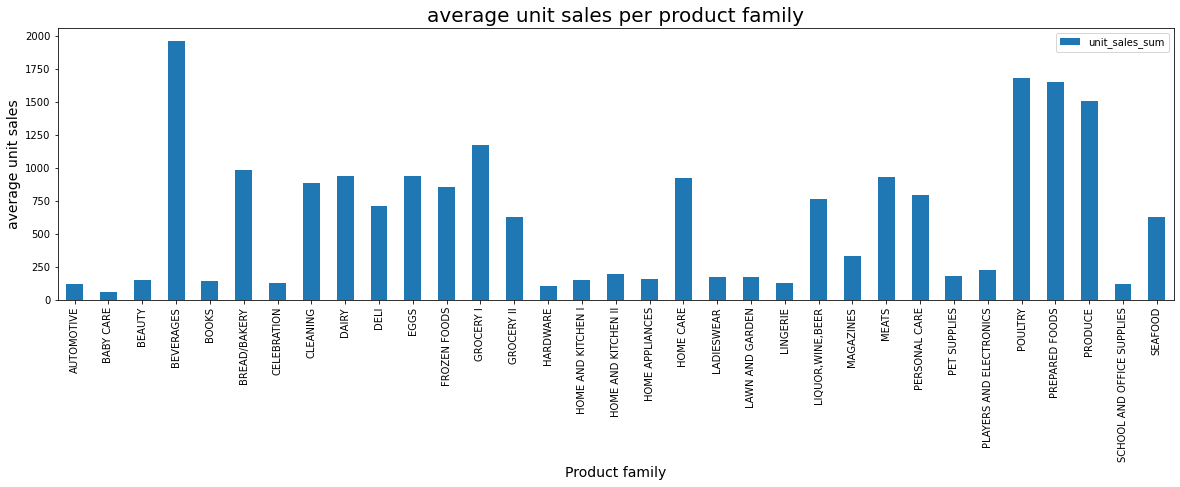

In [139]:
#average unit sales per product family
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'family','unit_sales_sum','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='family',y='unit_sales_sum')

plot.set_title('average unit sales per product family', fontsize = 20)
plot.set_xlabel('Product family', fontsize = 14)
plot.set_ylabel('average unit sales', fontsize = 14);

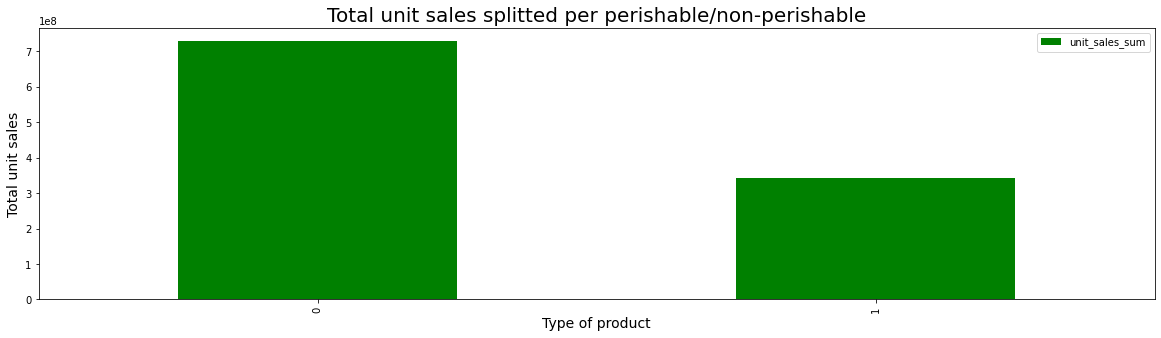

In [134]:
#total unit sales splitted per perishable/non-perishable
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'perishable','unit_sales_sum','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='perishable',y='unit_sales_sum',color='green')

plot.set_title('Total unit sales splitted per perishable/non-perishable', fontsize = 20)
plot.set_xlabel('Type of product', fontsize = 14)
plot.set_ylabel('Total unit sales', fontsize = 14);

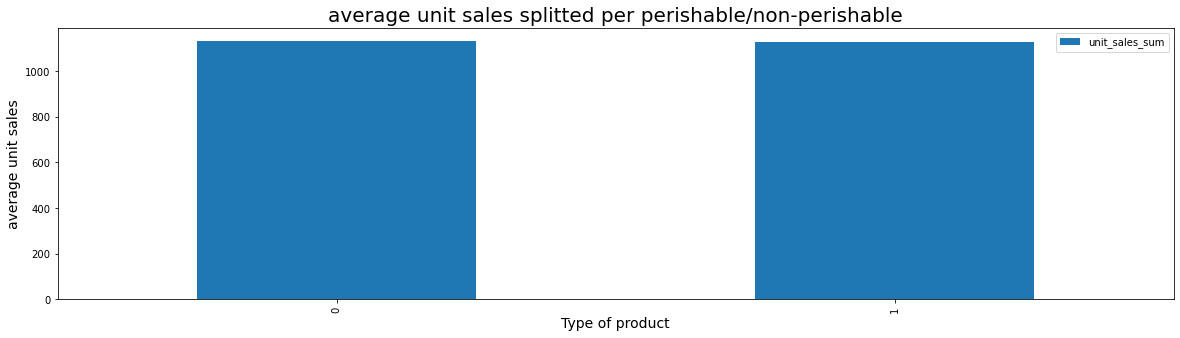

In [142]:
#average unit sales splitted per perishable/non-perishable
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'perishable','unit_sales_sum','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='perishable',y='unit_sales_sum')

plot.set_title('average unit sales splitted per perishable/non-perishable', fontsize = 20)
plot.set_xlabel('Type of product', fontsize = 14)
plot.set_ylabel('average unit sales', fontsize = 14);

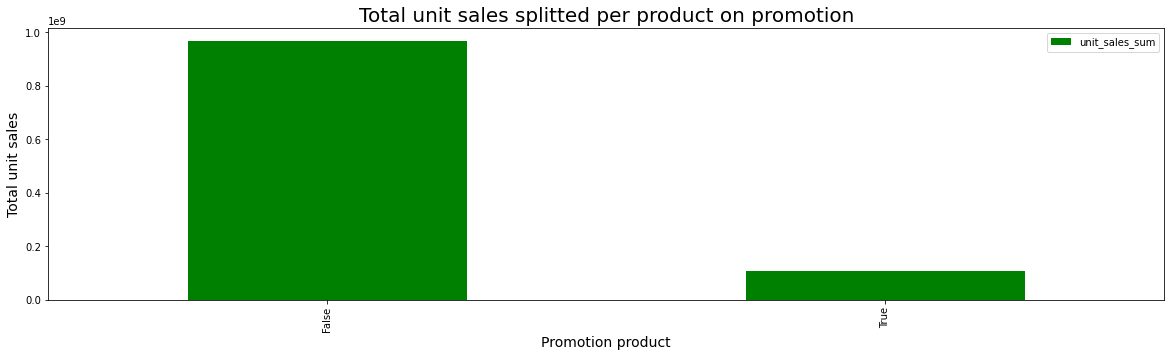

In [135]:
#total unit sales splitted per products on promotion
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'onpromotion','unit_sales_sum','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='onpromotion',y='unit_sales_sum',color='green')

plot.set_title('Total unit sales splitted per product on promotion', fontsize = 20)
plot.set_xlabel('Promotion product', fontsize = 14)
plot.set_ylabel('Total unit sales', fontsize = 14);

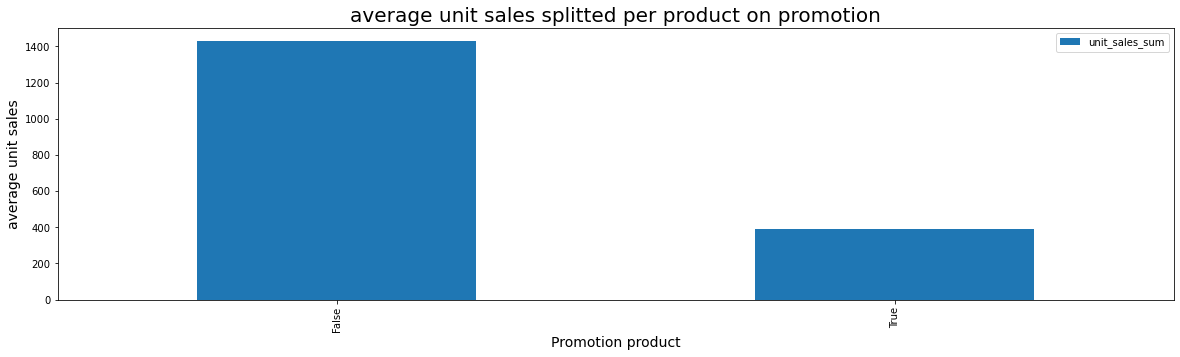

In [141]:
#average unit sales splitted per products on promotion
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'onpromotion','unit_sales_sum','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='onpromotion',y='unit_sales_sum')

plot.set_title('average unit sales splitted per product on promotion', fontsize = 20)
plot.set_xlabel('Promotion product', fontsize = 14)
plot.set_ylabel('average unit sales', fontsize = 14);

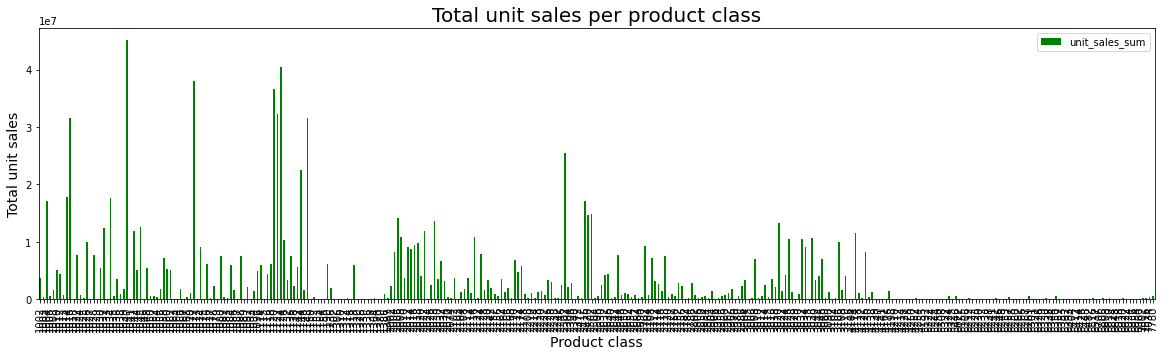

In [136]:
#total unit sales per product class
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'class','unit_sales_sum','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='class',y='unit_sales_sum',color='green')

plot.set_title('Total unit sales per product class', fontsize = 20)
plot.set_xlabel('Product class', fontsize = 14)
plot.set_ylabel('Total unit sales', fontsize = 14);

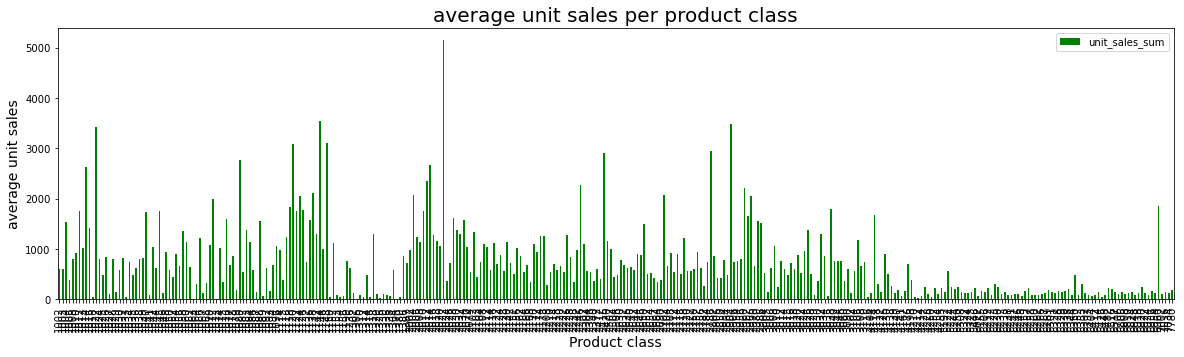

In [143]:
#average unit sales per product class
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'class','unit_sales_sum','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='class',y='unit_sales_sum',color='green')

plot.set_title('average unit sales per product class', fontsize = 20)
plot.set_xlabel('Product class', fontsize = 14)
plot.set_ylabel('average unit sales', fontsize = 14);

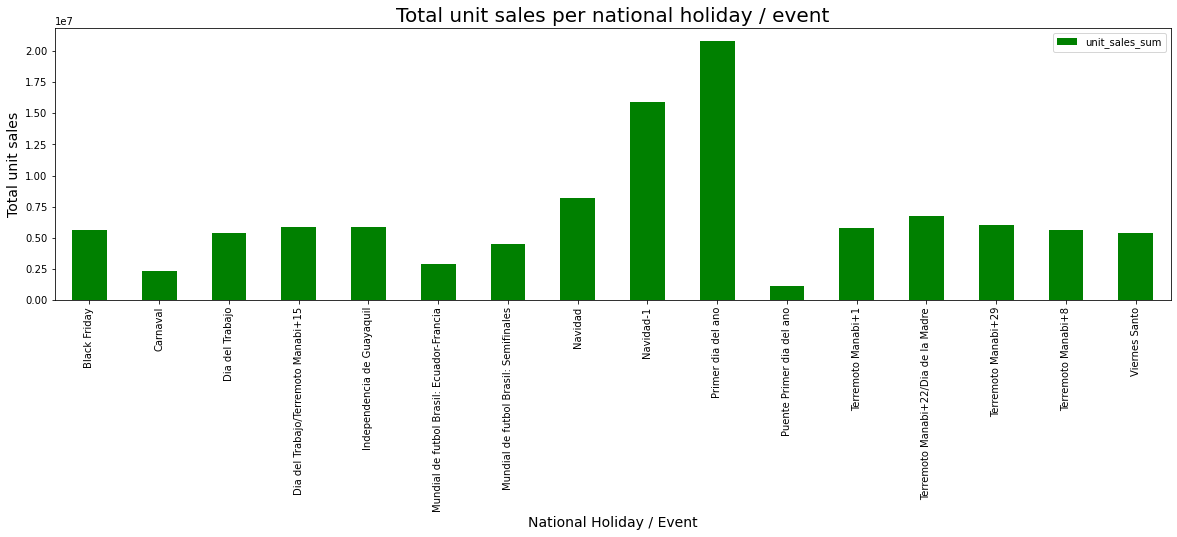

In [137]:
#total unit sales per national event / holiday
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'description_National','unit_sales_sum','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='description_National',y='unit_sales_sum',color='green')

plot.set_title('Total unit sales per national holiday / event', fontsize = 20)
plot.set_xlabel('National Holiday / Event', fontsize = 14)
plot.set_ylabel('Total unit sales', fontsize = 14);

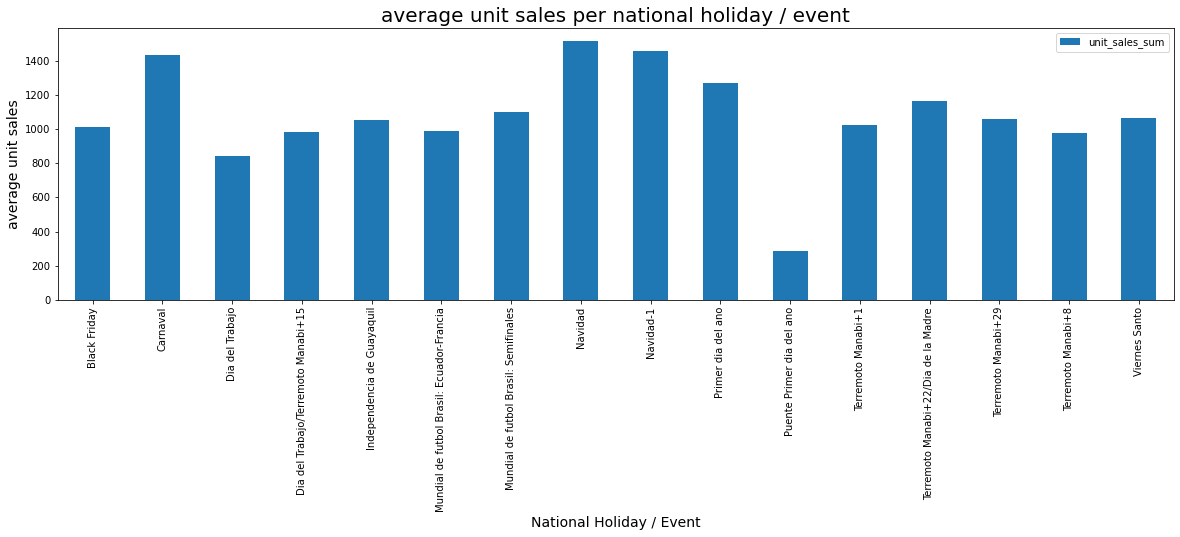

In [144]:
#average unit sales per national event / holiday
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'description_National','unit_sales_sum','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='description_National',y='unit_sales_sum')

plot.set_title('average unit sales per national holiday / event', fontsize = 20)
plot.set_xlabel('National Holiday / Event', fontsize = 14)
plot.set_ylabel('average unit sales', fontsize = 14);

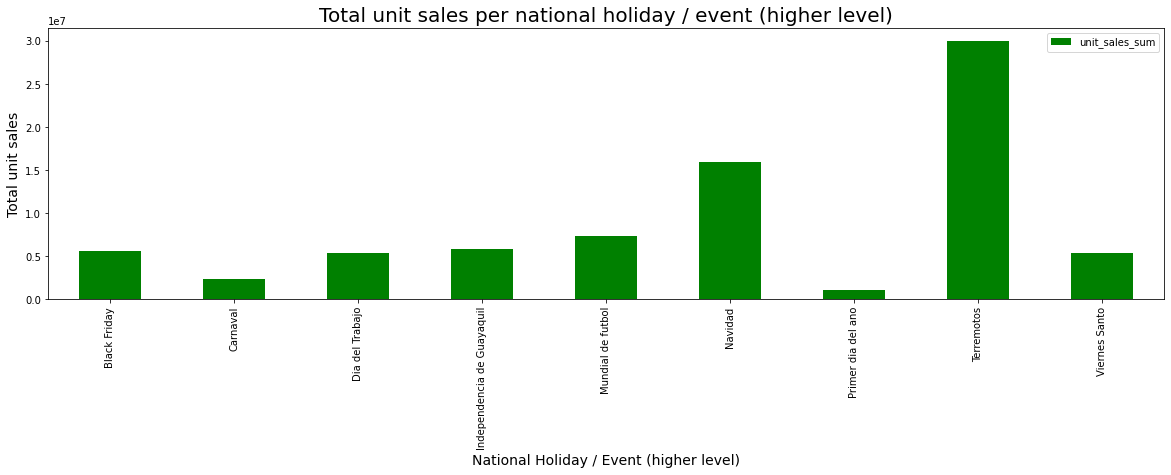

In [138]:
#total unit sales per national event / holiday (higher level)
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'description_National_Remapped','unit_sales_sum','sum')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='description_National_Remapped',y='unit_sales_sum',color='green')

plot.set_title('Total unit sales per national holiday / event (higher level)', fontsize = 20)
plot.set_xlabel('National Holiday / Event (higher level)', fontsize = 14)
plot.set_ylabel('Total unit sales', fontsize = 14);

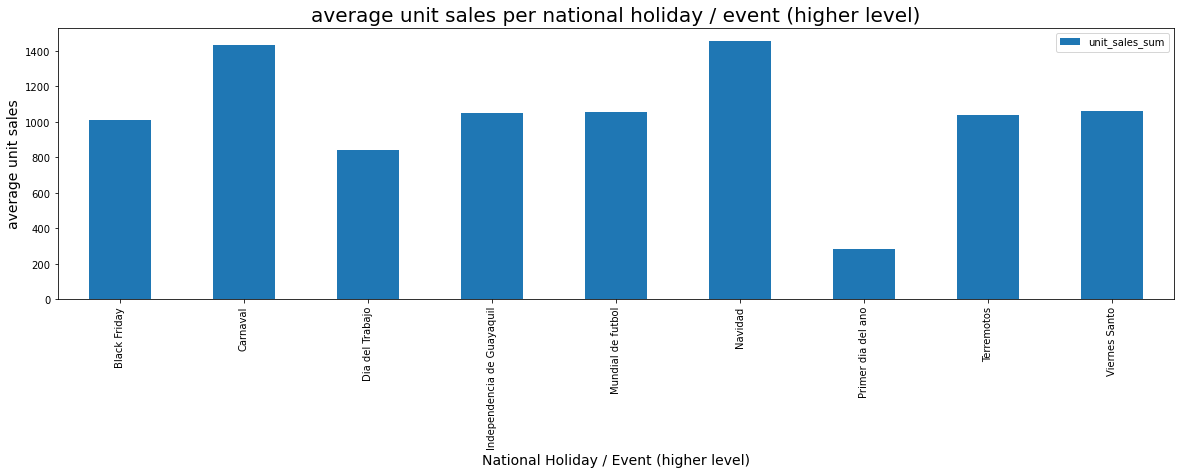

In [145]:
#average unit sales per national event / holiday (higher level)
df_temp_chart = aggregate_dataframe(df_dict['history_aggregated'],'description_National_Remapped','unit_sales_sum','mean')
plot = df_temp_chart.plot(kind='bar',figsize=(20,5), x='description_National_Remapped',y='unit_sales_sum')

plot.set_title('average unit sales per national holiday / event (higher level)', fontsize = 20)
plot.set_xlabel('National Holiday / Event (higher level)', fontsize = 14)
plot.set_ylabel('average unit sales', fontsize = 14);

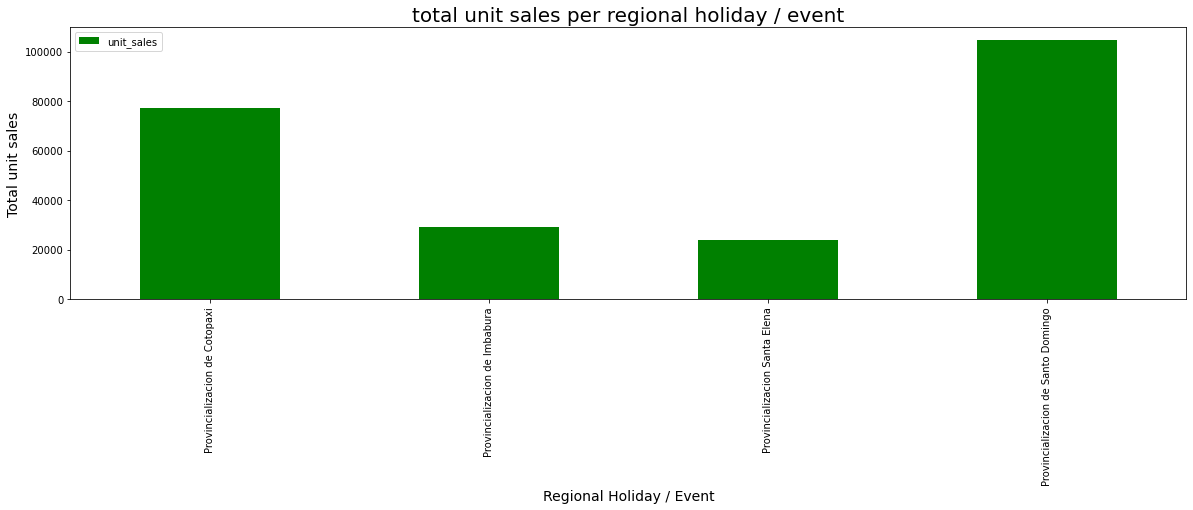

In [148]:
#total unit sales per regional event / holiday
groupby_fields = ['description_Regional']
dask_df_unit_sales_per_product = aggregate_dataframe(dask_df_history_enriched,groupby_fields,'unit_sales','sum')
df_unit_sales_per_product = dask_df_unit_sales_per_product.compute()


plot = df_unit_sales_per_product.plot(kind='bar',figsize=(20,5), x='description_Regional',y='unit_sales',color='green')

plot.set_title('total unit sales per regional holiday / event', fontsize = 20)
plot.set_xlabel('Regional Holiday / Event', fontsize = 14)
plot.set_ylabel('Total unit sales', fontsize = 14);

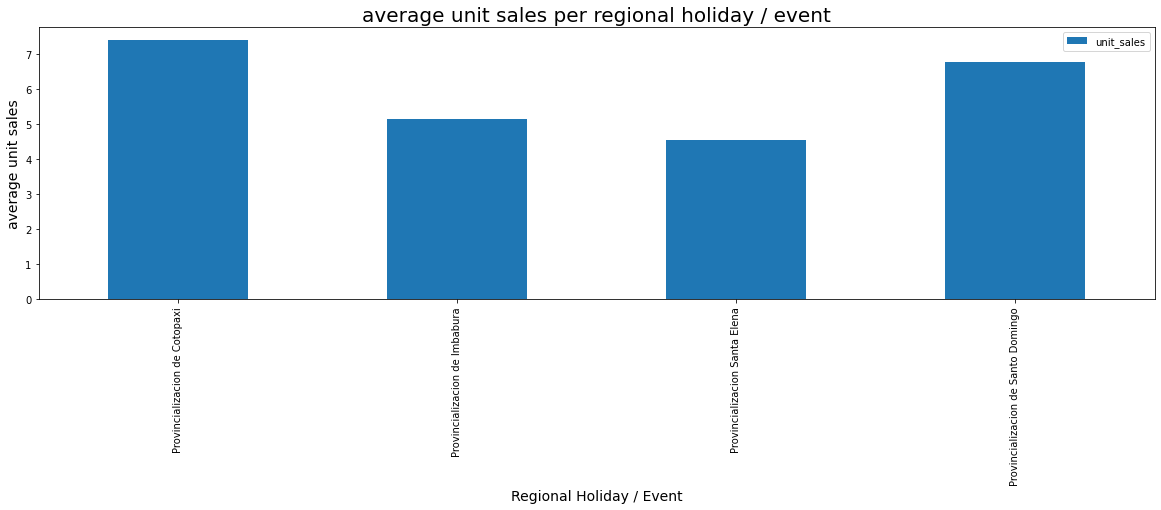

In [149]:
#average unit sales per regional event / holiday
groupby_fields = ['description_Regional']
dask_df_unit_sales_per_product = aggregate_dataframe(dask_df_history_enriched,groupby_fields,'unit_sales','mean')
df_unit_sales_per_product = dask_df_unit_sales_per_product.compute()


plot = df_unit_sales_per_product.plot(kind='bar',figsize=(20,5), x='description_Regional',y='unit_sales')

plot.set_title('average unit sales per regional holiday / event', fontsize = 20)
plot.set_xlabel('Regional Holiday / Event', fontsize = 14)
plot.set_ylabel('average unit sales', fontsize = 14);

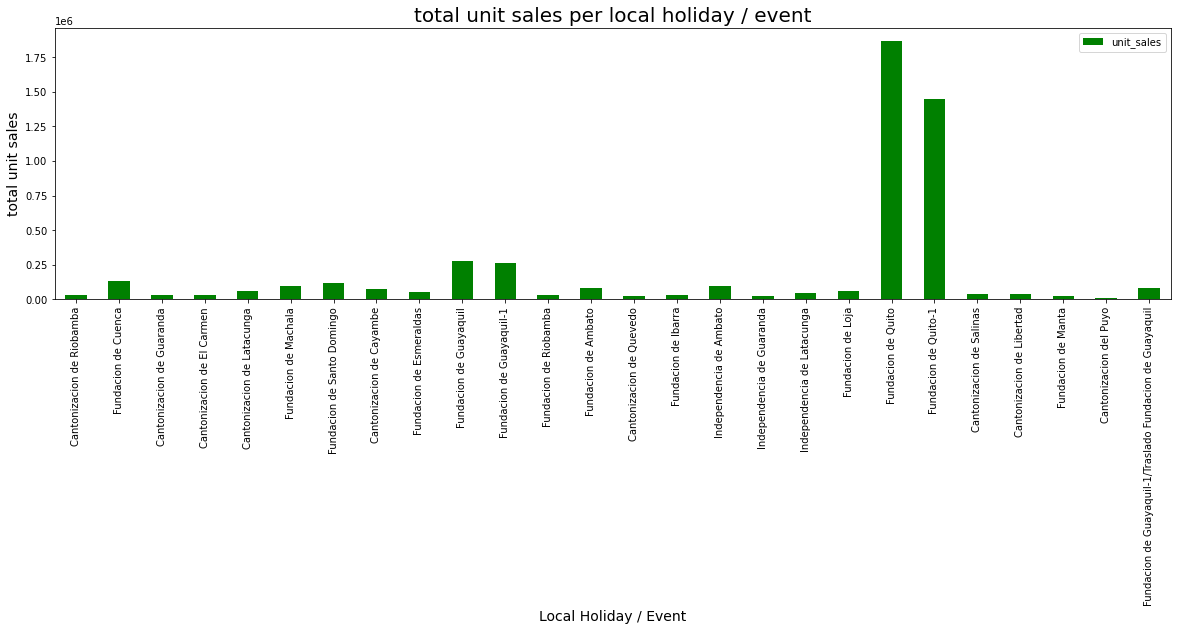

In [150]:
#total unit sales per local event / holiday
groupby_fields = ['description_Local']
dask_df_unit_sales_per_product = aggregate_dataframe(dask_df_history_enriched,groupby_fields,'unit_sales','sum')
df_unit_sales_per_product = dask_df_unit_sales_per_product.compute()


plot = df_unit_sales_per_product.plot(kind='bar',figsize=(20,5), x='description_Local',y='unit_sales',color='green')

plot.set_title('total unit sales per local holiday / event', fontsize = 20)
plot.set_xlabel('Local Holiday / Event', fontsize = 14)
plot.set_ylabel('total unit sales', fontsize = 14);

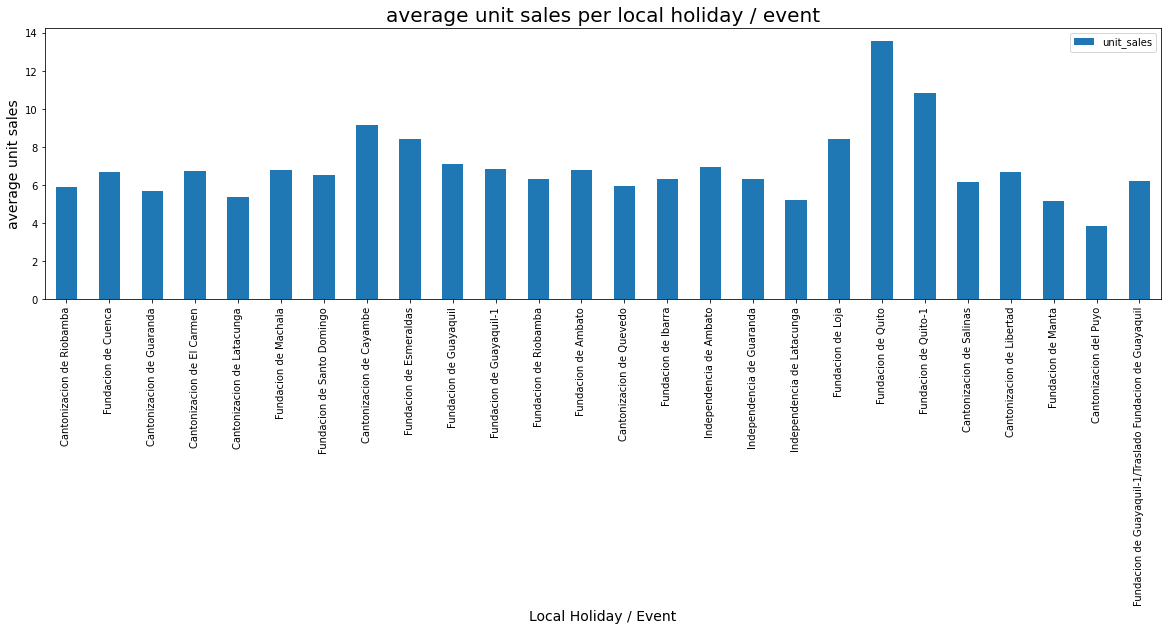

In [151]:
#average unit sales per local event / holiday
groupby_fields = ['description_Local']
dask_df_unit_sales_per_product = aggregate_dataframe(dask_df_history_enriched,groupby_fields,'unit_sales','mean')
df_unit_sales_per_product = dask_df_unit_sales_per_product.compute()


plot = df_unit_sales_per_product.plot(kind='bar',figsize=(20,5), x='description_Local',y='unit_sales')

plot.set_title('average unit sales per local holiday / event', fontsize = 20)
plot.set_xlabel('Local Holiday / Event', fontsize = 14)
plot.set_ylabel('average unit sales', fontsize = 14);

In [244]:
#plot history aggregated against oil price rrr
df_hist_agg = aggregate_dataframe(df_dict['history_aggregated'],'date','unit_sales_sum','sum')
df_hist_agg2 = df_hist_agg.merge(df_dict['oil'], how='left', left_on=['date'], right_on=['date'])
df_temp_chart = create_index_figures(df_hist_agg2,100,'unit_sales_sum','dcoilwtico','unit_sales','oil_price')

trace0 = go.Scatter(x = df_temp_chart['date'], y = df_temp_chart['unit_sales'], name = 'Unit sales', line = dict(color = ('rgb(0, 250, 24)'), width = 4), connectgaps = True)
trace1 = go.Scatter(x = df_temp_chart['date'], y = df_temp_chart['oil_price'], name = 'Oil Price', line = dict(color = ('rgb(205, 12, 24)'), width = 4, dash = 'dot'), connectgaps = True)

data = [trace0, trace1] # create list of the traces made earlier

#create dictionary with layout
layout = dict(title = 'Unit Sales vs. Oil Price (1-1-2013 = 100) ', xaxis = dict(title = 'Date'), yaxis = dict(title = 'Tourists'),)

#combine data and layout in figure
fig = dict(data = data, layout = layout)

offline.iplot(fig)




In [243]:
df_temp_chart.head()

date  unit_sales_sum  dcoilwtico  unit_sales   oil_price
0 2013-01-01      3333962.00         NaN  100.000000  100.000000
1 2013-01-08      2428673.75       93.21   72.846474         NaN
2 2013-01-15      2371373.50       93.26   97.640678  100.053642
3 2013-01-22      2302845.00       96.09   97.110176  103.034527
4 2013-01-29      2420965.75       97.62  105.129333  101.592257

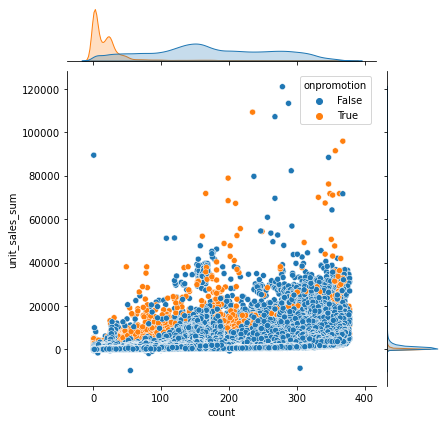

In [140]:
#relation between count and sales split by on promotion
sns.jointplot(x='count',y='unit_sales_sum',data=df_dict['history_aggregated'],hue='onpromotion');

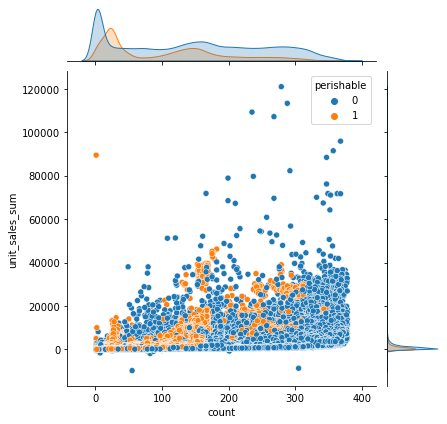

In [141]:
#relation between count and sales split by perishable/non-perishable
sns.jointplot(x='count',y='unit_sales_sum',data=df_dict['history_aggregated'],hue='perishable');

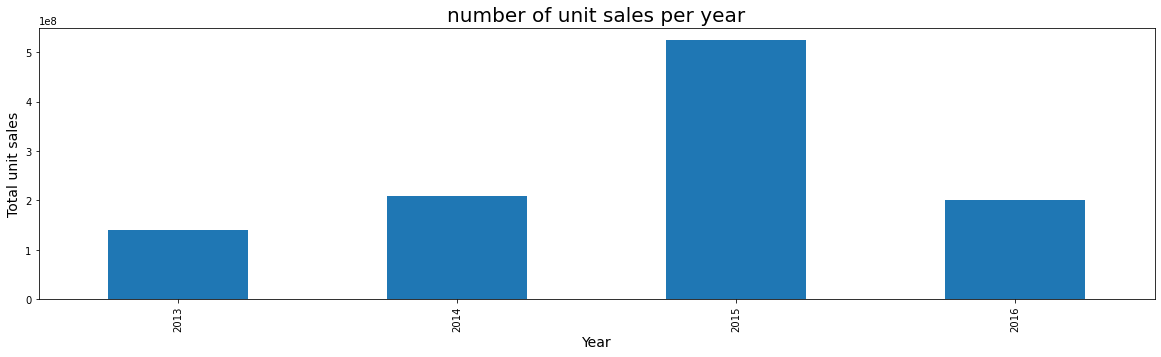

In [142]:
#number of transactions for a year
plot = df_dict['history_aggregated'].groupby(['year'])['unit_sales_sum'].sum().plot(kind='bar',figsize=(20,5), x='year',y='unit_sales_sum')

plot.set_title('number of unit sales per year', fontsize = 20)
plot.set_xlabel('Year', fontsize = 14)
plot.set_ylabel('Total unit sales', fontsize = 14);

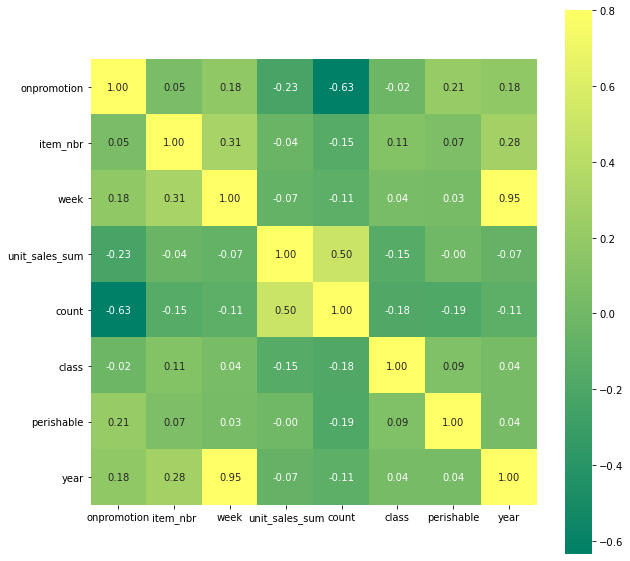

In [143]:
#correlation matrix
corrmat = df_dict['history_aggregated'].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f',cmap='summer')
plt.show()